In [68]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
import os
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error, r2_score

Source of knowledge: https://towardsdatascience.com/the-complete-guide-to-time-series-forecasting-using-sklearn-pandas-and-numpy-7694c90e45c1

In [69]:
%run Modeling_Utils.ipynb

## Load Data

In [70]:
load_data = LoadData()
PM_data = load_data.load_PM_data()
Rain_data = load_data.load_Rain_data()

## Pre-processing

In [71]:
# Start with rain data
rain_TS = pd.concat([value.set_index('Date') for value in Rain_data.copy().values()], axis=0).fillna(0).rename(columns={'73T':'Rain_73T'})
rain_TS.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2018-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Rain_73T  1096 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB


<AxesSubplot: xlabel='Date'>

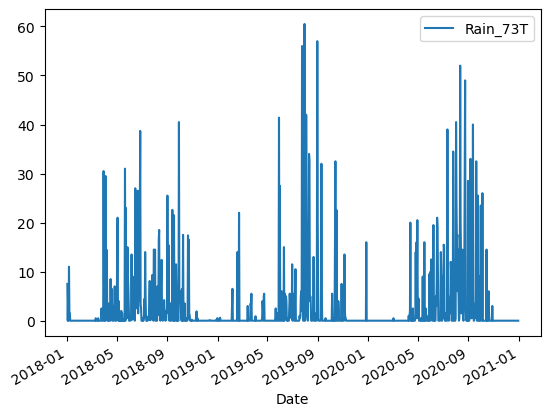

In [72]:
rain_TS.plot()

In [73]:
scope_year = [2018, 2019, 2020]
PM_TS = station_data_TS(PM_data, '73T', scope_year=scope_year)
PM_TS.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1092 entries, 2020-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM_73T  1092 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB


<AxesSubplot: xlabel='Date'>

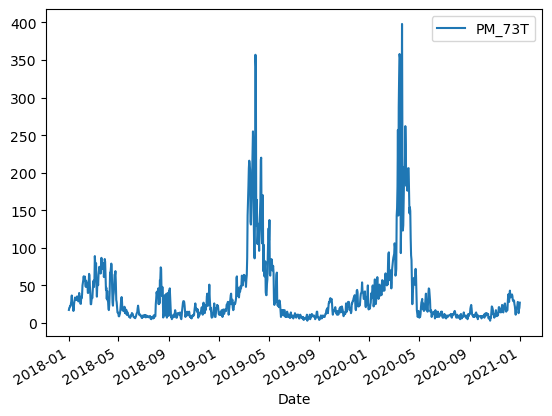

In [74]:
PM_TS.plot()

In [75]:
Data = pd.concat([rain_TS, PM_TS], axis=1)
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2018-01-01 to 2020-12-31
Freq: D
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Rain_73T  1096 non-null   float64
 1   PM_73T    1092 non-null   float64
dtypes: float64(2)
memory usage: 25.7 KB


In [76]:
Data[Data['PM_73T'].isna()]

,Rain_73T,PM_73T
Date,,
2018-06-29,2.7,NaN
2019-06-29,0.5,NaN
2020-02-29,0.0,NaN
2020-06-29,0.0,NaN


<AxesSubplot: xlabel='Date'>

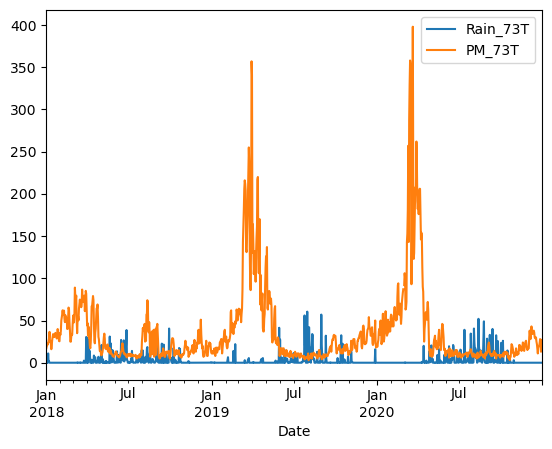

In [77]:
Data.plot()

In [78]:
# Fill nan on PM
Data['PM_73T'] = Data['PM_73T'].interpolate('linear')
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2018-01-01 to 2020-12-31
Freq: D
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Rain_73T  1096 non-null   float64
 1   PM_73T    1096 non-null   float64
dtypes: float64(2)
memory usage: 25.7 KB


<AxesSubplot: xlabel='Date'>

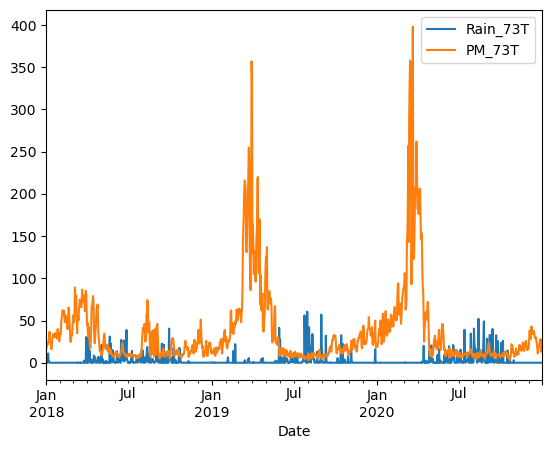

In [79]:
Data.plot()

In [80]:
# Data['Date_num'] = np.arange(Data.shape[0])
# Data

## Time series analysis

### Trend

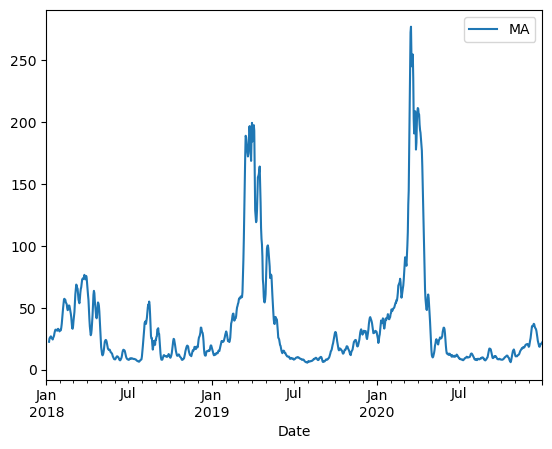

In [81]:
# Moving average
ax = Data.PM_73T.rolling(7).mean().plot(label='MA')
# ax = Data.PM_73T.plot(ax=ax, label='Raw')
ax.legend()

### No trend

### Seasonality

In [82]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    # ax.set_xscale("log")
    # ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    # ax.set_xticklabels(
    #     [
    #         "Annual (1)",
    #         "Semiannual (2)",
    #         "Quarterly (4)",
    #         "Bimonthly (6)",
    #         "Monthly (12)",
    #         "Biweekly (26)",
    #         "Weekly (52)",
    #         "Semiweekly (104)",
    #     ],
    #     rotation=30,
    # )
    # ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

/var/folders/gf/fktly7290j31znhhqnp98ddw0000gn/T/ipykernel_3897/1015289302.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  ax = plot_periodogram(Data.PM_73T)


(0.0, 5.0)

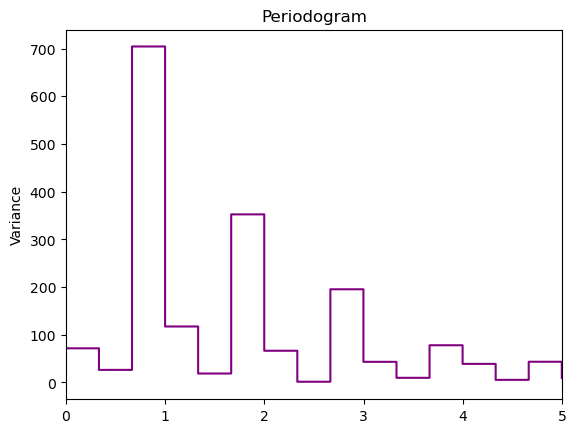

In [83]:
ax = plot_periodogram(Data.PM_73T)
ax.set_xlim([0, 5])

In [84]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=5)

dp = DeterministicProcess(index=Data.index, constant=True, order=1, additional_terms=[fourier], drop=True)

X = dp.in_sample()
y = Data.PM_73T

['sin(1,freq=A-DEC)',
 'cos(1,freq=A-DEC)',
 'sin(2,freq=A-DEC)',
 'cos(2,freq=A-DEC)',
 'sin(3,freq=A-DEC)',
 'cos(3,freq=A-DEC)',
 'sin(4,freq=A-DEC)',
 'cos(4,freq=A-DEC)',
 'sin(5,freq=A-DEC)',
 'cos(5,freq=A-DEC)']

<AxesSubplot: xlabel='Date'>

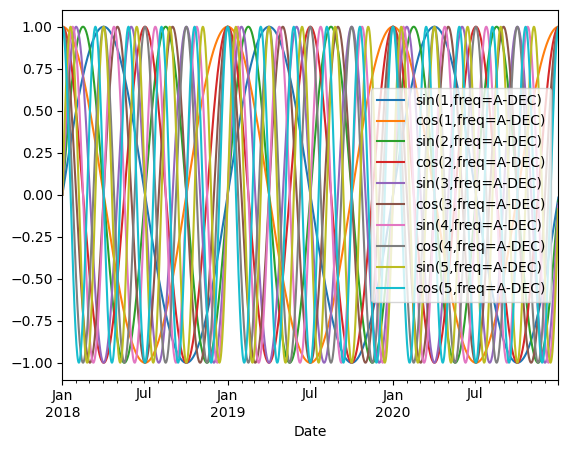

In [116]:
X.loc[:, [i for i in X.columns if 'sin' in i or 'cos' in i]].plot()

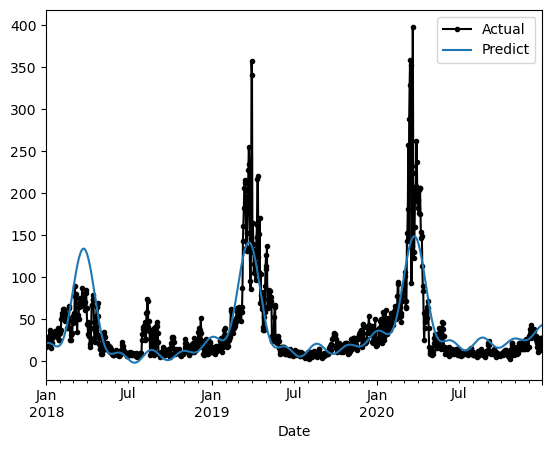

In [91]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=Data.index)

ax = y.plot(style='.-', color='k', label='Actual')
ax = y_pred.plot(ax=ax, label='Predict')
ax.legend()

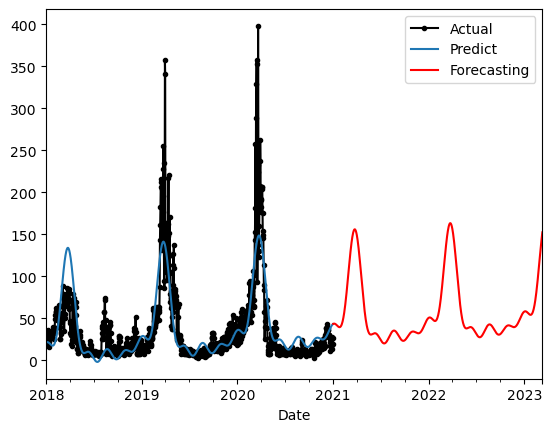

In [92]:
# Forecasting

X_fore = dp.out_of_sample(800)

y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(style='.-', color='k', label='Actual')
ax = y_pred.plot(ax=ax, label='Predict')
ax = y_fore.plot(ax=ax, color='red', label='Forecasting')
ax.legend()

<AxesSubplot: xlabel='Date'>

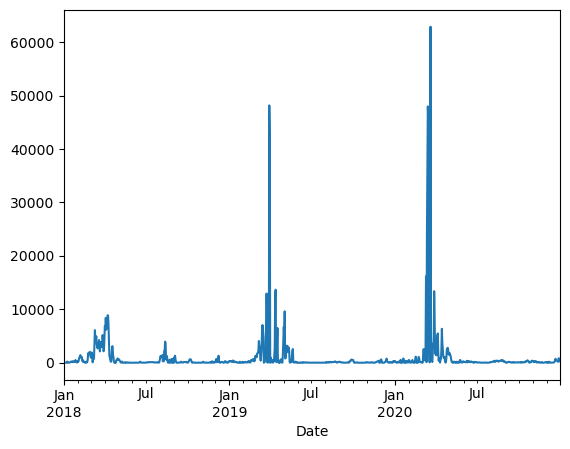

In [110]:
MSE = pd.concat([y.rename('Actual'), y_pred.rename('Predicted')], axis=1).diff(axis=1).fillna(0).sum(axis=1).rename('mean_squared_error') ** 2
MSE.plot()

### Serial dependence
- Improve model with leading and lagging indicators

In [118]:
from statsmodels.graphics.tsaplots import plot_pacf

def make_lags(ts, lags):
    return pd.concat({f'y_lag_{i}': ts.shift(i) for i in range(1, lags + 1)}, axis=1)

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

/Users/namtipyass/miniforge3/envs/tf/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


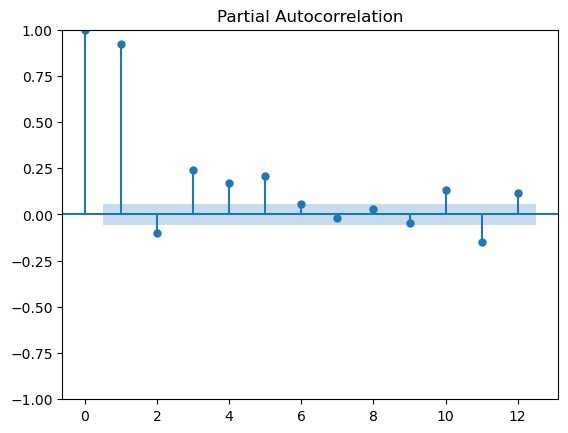

In [120]:
plot_pacf(y, lags=12)
plt.show()

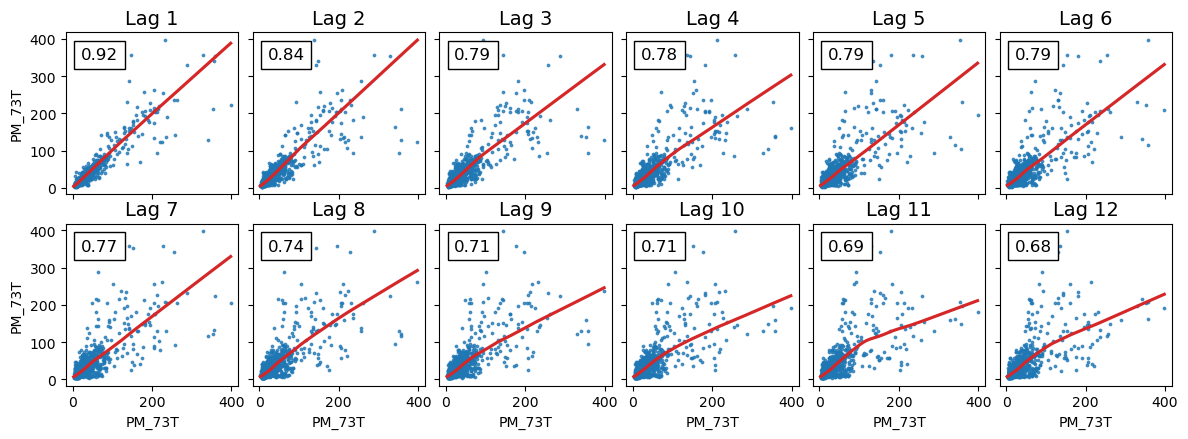

In [123]:
_ = plot_lags(y, lags=12, nrows=2)

In [ ]:
# lagging
X = make_lags()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)